# Santander Customer Transaction Prediction

In [167]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, confusion_matrix
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import seaborn as sns


train_df = pd.read_csv("../project/data/train_small.csv", header=None)
test_df = pd.read_csv("../project/data/test_small.csv")

train_df.columns = list([test_df.columns[0],"target",*test_df.columns[1:]])

/home/shomed/m/martinob/Documents/host2019/VisInt/venv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Data Preprocessing

In [2]:
response = np.array(train_df['target'])
features = np.array(train_df.iloc[:,2:])
features_list = list(train_df.iloc[:,2:].columns)

from sklearn.model_selection import train_test_split
train_features, test_features, train_response, test_response = train_test_split(features, response, test_size = 0.25, random_state = 42)


In [3]:
print("train: ", 100*train_response.sum()/train_response.size,"   test: ", 100*test_response.sum()/test_response.size)

train:  10.009135548703894    test:  9.865829289180702


## Feature Selection 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100, random_state = 42, verbose = 10,n_jobs = -1)

rf.fit(train_features, train_response)



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


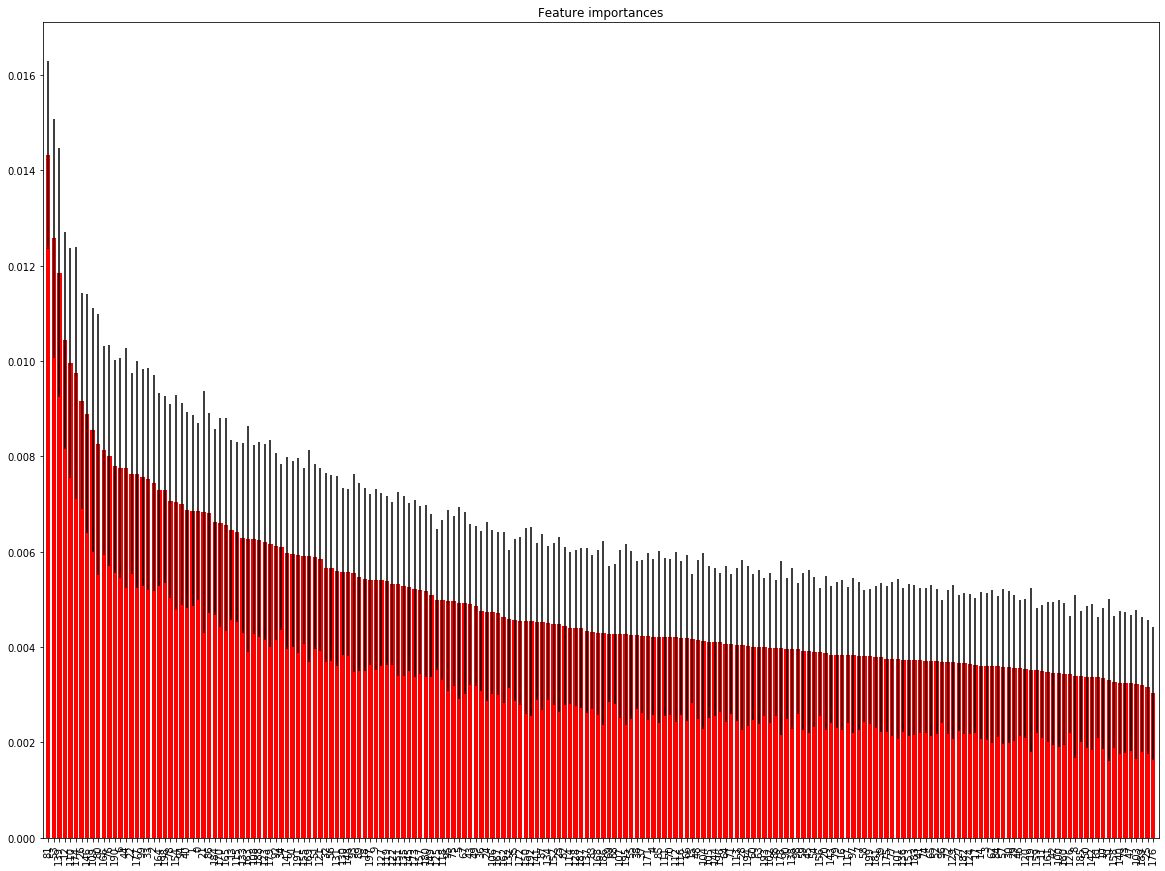

In [12]:
preds = rf.predict(test_features)
pd.crosstab(test_response, preds, rownames=['Actual Value'], colnames=['Predicted Value'])

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Plot the feature importances of the forest
plt.figure(figsize = (20,15))
plt.title("Feature importances")
plt.bar(range(test_features.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(test_features.shape[1]), indices, rotation='vertical')
plt.xlim([-1, test_features.shape[1]])
plt.show()

In [26]:
importances.min()

0.003029442174168279

In [163]:
def plt_density(df, var):
    plt.figure(figsize = (10,10))
    sns.distplot(train_df.loc[train_df['target'] == 0,var],hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 3}, 
                      label = "target = 0")
    sns.distplot(train_df.loc[train_df['target'] == 1,var],hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 3}, 
                      label = "target = 1")

    plt.title('Density Plot of ' + var)
    plt.xlabel(var)
    plt.ylabel('Density')
    plt.show()

# 3,4,7,10,11,14,15,16,17,19,20,23,25,27,29,30,31,32,37,38,39,41,42,45,46,47,50,52,54,55,57,59,60,61,63,64,65,68,69,72,73,77,79,82,83,84,85,89,90,96,97,98,100,101,102
# 103,104,105,,113,116,117,120,124,126,128,129

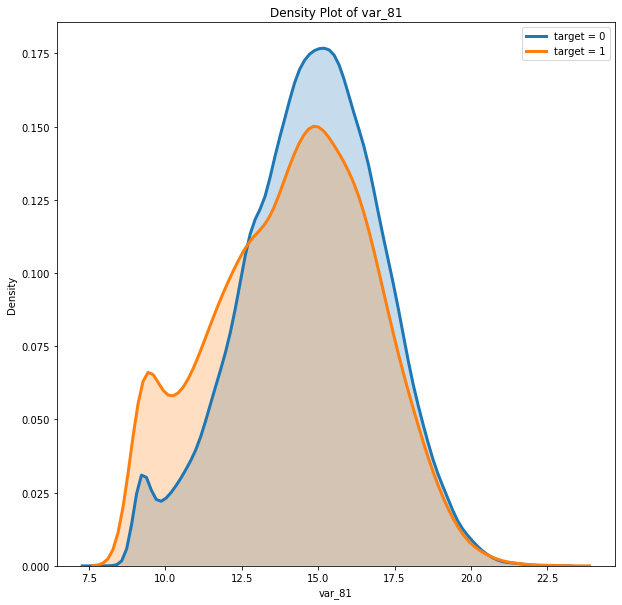

In [200]:
plt_density(train_df, 'var_81')

## Hyperparameter Tuning

In [58]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.sum(errors)/test_labels.size
    accuracy = 100 - mape
    fpr, tpr, thresholds = roc_curve(test_labels, predictions)
    plt.figure(figsize = (10,10))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.show()
    decision_boundary = 0.18
    predictions[predictions < decision_boundary] = 0
    predictions[predictions >= decision_boundary] = 1
    conf_mat = confusion_matrix(test_labels, predictions)
    print('Model Performance')
    print(conf_mat)
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

## Random search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# First create the base model to tune
rf = RandomForestRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(train_features, train_response);

In [ ]:
rf_random.best_params_

In [ ]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(train_features, train_labels)
base_accuracy = evaluate(base_model, test_features, test_labels)

In [32]:
best_params_random = joblib.load("../project/best_params_rf.pkl")
best_estimator_random= joblib.load("../project/best_estimator_rf.pkl")
best_params_random

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 30,
 'bootstrap': False}

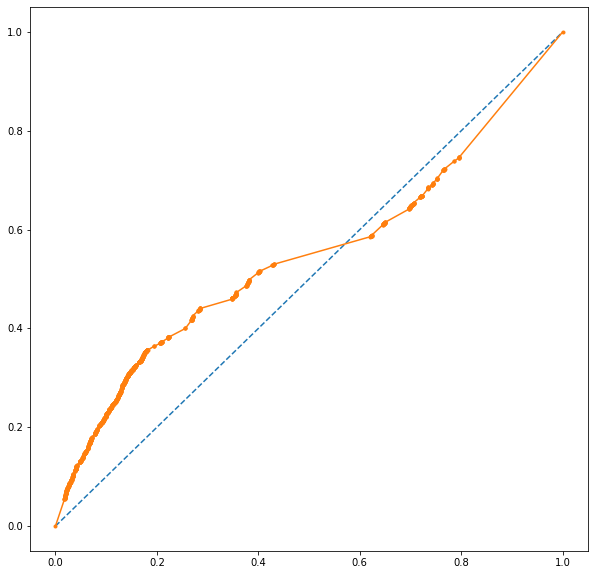

Model Performance
[[13793  1994]
 [ 1265   463]]
Accuracy = 83.76%.


In [59]:
random_accuracy = evaluate(best_estimator_random, test_features, test_response)

## Grid search 1

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [20, 30, 40],
    'max_features': [2, 3],
    'min_samples_leaf': [4, 5, 6],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [1800, 2000, 2200]
}

# Create a base model
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)
grid_search.fit(train_features, train_labels)

In [ ]:
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)

### Grid search 2

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [110, 120, None],
    'max_features': [3, 4],
    'min_samples_leaf': [5, 6, 7],
    'min_samples_split': [10],
    'n_estimators': [75, 100, 125]
}

# Create a base model
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search_final = GridSearchCV(estimator = rf, param_grid = param_grid, 
                                 cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

grid_search_final.fit(train_features, train_labels);

In [ ]:
grid_search_final.best_params_

In [ ]:
best_grid_final = grid_search_final.best_estimator_
grid_final_accuracy = evaluate(best_grid_final, test_features, test_labels)

In [ ]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

# Logistic Regression

## Over Sampling

In [3]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
os_features,os_response=os.fit_sample(train_features, train_response)


Using TensorFlow backend.


In [4]:
print("length of oversampled data is ",len(os_features))
print("Number of 0 labels in oversampled data",len(os_response[os_response==0]))
print("Number of 1 labels",len(os_response[os_response==1]))
print("Proportion of 0 labels in oversampled data is ",len(os_response[os_response==0])/len(os_features))
print("Proportion of 1 labels in oversampled data is ",len(os_response[os_response==1])/len(os_features))

length of oversampled data is  94566
Number of 0 labels in oversampled data 47283
Number of 1 labels 47283
Proportion of 0 labels in oversampled data is  0.5
Proportion of 1 labels in oversampled data is  0.5


In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='lbfgs',max_iter=1000)
rfe = RFECV(logreg, min_features_to_select  = 20, step=1, cv=5, n_jobs = -1, verbose = 10)
rfe = rfe.fit(os_features, os_response)

In [10]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs',max_iter = 10000)
logreg.fit(os_features, os_response)

y_pred = logreg.predict(test_features)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(test_features, test_response)))


Accuracy of logistic regression classifier on test set: 0.79


## Model evaluation

In [18]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(test_response, y_pred)
print(conf_mat)

[[12475  3312]
 [  402  1326]]


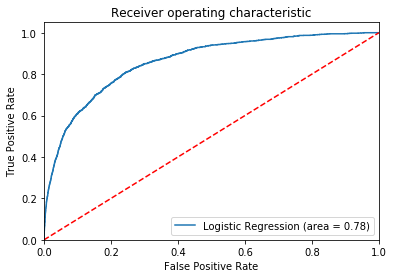

In [12]:
logit_roc_auc = roc_auc_score(test_response, logreg.predict(test_features))
fpr, tpr, thresholds = roc_curve(test_response, logreg.predict_proba(test_features)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [25]:
specificity = conf_mat[0,0]/(conf_mat[0,0] + conf_mat[0,1])
sensitivity = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1])
print("specificity=", specificity,"  sensitivity=",sensitivity)

specificity= 0.7902071324507506   sensitivity= 0.7673611111111112


## Neural Network

In [29]:
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical
import tensorflow as tf


def create_mlp():
    model = models.Sequential()
    model.add(layers.Dense(1028,activation = 'relu',input_dim=200))
    model.add(layers.Dense(512,activation = 'relu'))
    model.add(layers.Dense(256,activation = 'relu'))
    model.add(layers.Dense(128,activation = 'relu'))
    model.add(layers.Dense(2,activation = 'softmax'))
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return(model)

def create_callbacks(mod):
    filepath = "models/best-weights-mlp.hdf5"
    model_checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    return([model_checkpoint])

In [24]:
x_train = normalize(os_features, axis=0)

In [31]:
from sklearn.preprocessing import normalize
x_train = normalize(os_features, axis=0)
y_train = to_categorical(os_response, num_classes=2)
#y_train = train_response
x_test = normalize(test_features, axis=0)
y_test = to_categorical(test_response, num_classes=2)
#y_test = test_response
model = create_mlp()
callbacks_list = create_callbacks("mlp")
history = model.fit(x_train, 
                    y_train, 
                    epochs=20,
                    validation_data=(x_test,y_test),
                    callbacks = callbacks_list
                   )

Train on 94566 samples, validate on 17515 samples
Epoch 1/20
94368/94566 [============================>.] - ETA: 0s - loss: 0.5330 - accuracy: 0.7250
Epoch 00001: val_accuracy improved from -inf to 0.90711, saving model to models/best-weights-mlp.hdf5
94566/94566 [==============================] - 25s 263us/sample - loss: 0.5330 - accuracy: 0.7250 - val_loss: 0.3007 - val_accuracy: 0.9071
Epoch 2/20
94400/94566 [============================>.] - ETA: 0s - loss: 0.4848 - accuracy: 0.7646
Epoch 00002: val_accuracy improved from 0.90711 to 0.90722, saving model to models/best-weights-mlp.hdf5
94566/94566 [==============================] - 24s 257us/sample - loss: 0.4848 - accuracy: 0.7646 - val_loss: 0.5617 - val_accuracy: 0.9072
Epoch 3/20
94496/94566 [============================>.] - ETA: 0s - loss: 0.4437 - accuracy: 0.7931
Epoch 00003: val_accuracy did not improve from 0.90722
94566/94566 [==============================] - 25s 260us/sample - loss: 0.4436 - accuracy: 0.7932 - val_loss

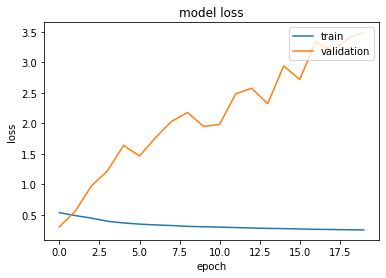

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Naive Bayes Classifier

The naive bayes Classifier comes from Bayes theorem 
\begin{equation*}
 P(\mathbf{y}|\mathbf{X}) = \frac{P(\mathbf{X}|\mathbf{y})P(\mathbf{y})}{P(\mathbf{X})},
\end{equation*}
which means that we can find the probability for classification $\mathbf{y}$ based on the features $\mathbf{X}$. The naive part of this classifier is the assumptions that the features are independent i.e. $P(\mathbf{x}_i,\mathbf{x}_j) = P(\mathbf{x}_i)P(\mathbf{x}_j)$.
The features are contained in the vector $\mathbf{X} = (\mathbf{x}_1, \mathbf{x}_2,\dots,\mathbf{x}_{200})$ and thereby we can rewrite bayes theorem to 
\begin{equation*}
 P(\mathbf{y}|\mathbf{X}) = \frac{P(\mathbf{x}_1|\mathbf{y})P(\mathbf{x}_2|\mathbf{y})\dots P(\mathbf{x}_{200}|\mathbf{y})P(\mathbf{y})}{P(\mathbf{x}_1)P(\mathbf{x}_2)\dots P(\mathbf{x}_{200})}.
\end{equation*}
The denominator in this is constant and we can rewrite the expression to
\begin{equation*}
P(\mathbf{y}|\mathbf{X}) \propto P(\mathbf{y}) \prod\limits_{i = 1}^{200} P(\mathbf{x}_i|\mathbf{y}),
\end{equation*}
thereby yielding the classifier 
\begin{equation*}
    y = \underset{y}{\mathrm{argmax}} P(y) \prod\limits_{i = 1}^{200} P(\mathbf{x}_i|y).
\end{equation*}

Furthermore we need to define the prior $P(y)$ and the likelihood $P(\mathbf{X}_i|y)$. Our prior belief about $y$ would be the distribution of class $1$ or $0$ labels, which is yields the bernoulli distribution $P(y = 1) \approx 0.1$ and $P(y = 0) \approx 0.9$. 
The choice of likelihood functions is done by looking at the distributions of $\mathbf{X}_i|y = j$. Below we import the dataset with a train/test = $0.9/0.1$, and then we visualize the distribution of 'var_3'.

In [164]:
from datasets import get_datasets
datasets = get_datasets()

In [165]:
from sklearn.naive_bayes import GaussianNB
data = datasets.small.resplit(0.9,0,0.1)

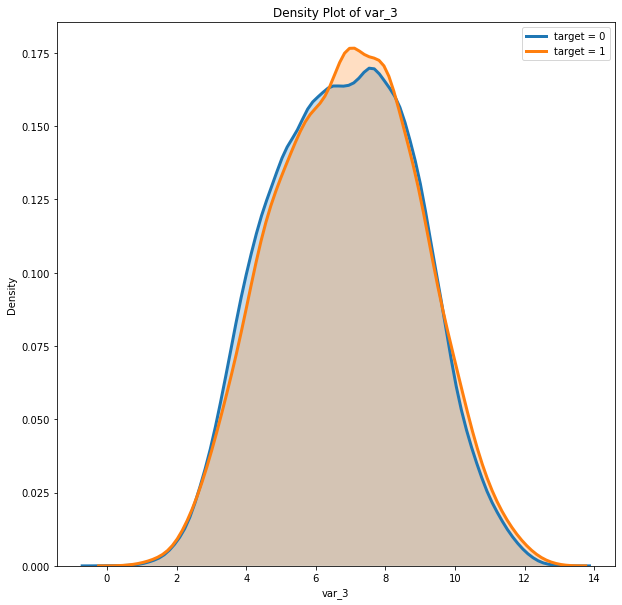

In [171]:
plt_density(data.train_split.X, 'var_3')

As seen see the the distribution above  is has some similarities with the Gaussian distribution. This is not true for all featues, however we make this assumption and set the likelihood to follow the Gaussian distribution given by the equation 
\begin{equation*}
    x_i|y=j \sim \frac{1}{\sqrt{2\pi\sigma_y^2}}\exp\left(-\frac{(x_i - \mu_y)^2}{2\sigma_y^2}\right),
\end{equation*}
where $\mu_y = E(x_i|y = j)$ and $\sigma_y^2 = Var(x_i|y = j)$. If you were to manually program this it would be to take the column mean and standard deviation given the target value $y = j$ where $j \in \{0,1\}$. Thereby using these as the parameters in the distribution of the likelihood.

In [3]:
data.summary()

### DataSet summary

__Train size:__ 70057 __Class balance:__ 90.03% / 10.0%

#### Sub-splits

__Train, validation, test split__ = (0.9, 0, 0.1)

__Train split size:__ 63051 __Class balance:__ 90.03% / 10.0%

__Test split size:__ 7006 __Class balance:__ 90.02% / 10.0%

In [172]:
gnb = GaussianNB()
gnb_model = gnb.fit(data.train_split.X, data.train_split.y)

In [173]:
y_pred = gnb_model.predict_proba(data.test_split.X)

### Evaluation Report

__PRC AUC Score:__ 0.61767

__ROC AUC Score:__ 0.90121



_Following statistics calculated with cut-off = 0.5_

__Accuracy:__ 92.51%

__Balanced Accuracy:__ 68.68%


__Sensitivity:__ 38.91%

__Specificity:__ 98.45%

__Class 1 Precision:__ 73.51%

__Class 1 Recall:__ 38.91%

,Condition Positive,Condition Negative
Positive Prediction,272,98
Negative Prediction,427,6209


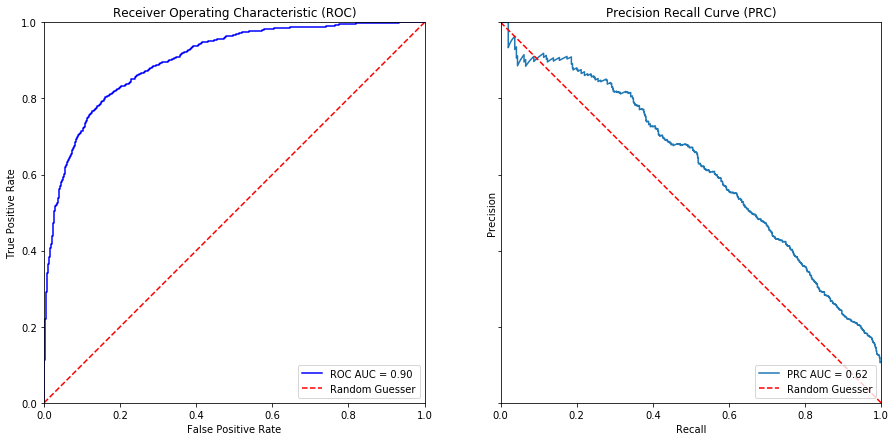

In [174]:
data.evaluate(y_pred[:,1],plot_roc = True)

# xgboost

In [62]:
import xgboost as xgb

dtrain = xgb.DMatrix(data.train_split.X,data.train_split.y)
dtest = xgb.DMatrix(data.test_split.X,data.test_split.y)
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'binary:logistic',
}
params['eval_metric'] = "auc"
num_boost_round = 999

/home/shomed/m/martinob/Documents/host2019/VisInt/venv/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [63]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)


[0]	Test-auc:0.644293
Will train until Test-auc hasn't improved in 10 rounds.
[1]	Test-auc:0.672547
[2]	Test-auc:0.688988
[3]	Test-auc:0.711283
[4]	Test-auc:0.727688


KeyboardInterrupt: 

## max_depth and min_child_weigth

In [64]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [65]:
# Define initial best params and MAE
min_auc = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_auc= cv_results['test-auc-mean'].min()
    boost_rounds = cv_results['test-auc-mean'].argmin()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc < min_auc:
        min_auc = mean_auc
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], min_auc))

CV with max_depth=9, min_child_weight=5


KeyboardInterrupt: 

In [ ]:
params['max_depth'] = 10
params['min_child_weight'] = 6

## Subsample and colsample

In [ ]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [ ]:
min_auc = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_auc = cv_results['test-auc-mean'].min()
    boost_rounds = cv_results['test-auc-mean'].argmin()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc < min_auc:
        min_auc = mean_auc
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_auc))

In [ ]:
params['subsample'] = .8
params['colsample_bytree'] = 1.

## Learning rate

In [ ]:
min_auc = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics=['auc'],
            early_stopping_rounds=10
          )
    # Update best score
    mean_auc = cv_results['test-auc-mean'].min()
    boost_rounds = cv_results['test-auc-mean'].argmin()
    print("\tAUC {} for {} rounds\n".format(mean_auc, boost_rounds))
    if mean_auc < min_auc:
        min_auc= mean_auc
        best_params = eta
print("Best params: {}, AUC: {}".format(best_params, min_auc))

In [ ]:
params['eta'] = .01

## Results

In [52]:

params = {
    'max_depth':10,
    'eta':.01,
    'subsample': 0.8,
    'eval_metric': 'auc',
    'min_child_weight': 6,
    'colsample_bytree': 1.0,
    'objective':'binary:logistic'
}

In [ ]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

In [ ]:
model2 = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10,
    xgb_model=model
)

### Evaluation Report

__AUC Score:__ 0.89141


_Following statistics calculated with cut-off = 0.5_

__Accuracy:__ 90.69%

__Sensitivity:__ 7.73%

__Specificity:__ 99.89%

__Precision:__ 88.52%

__Recall:__ 7.73%

,Condition Positive,Condition Negative
Positive Prediction,54,7
Negative Prediction,645,6300


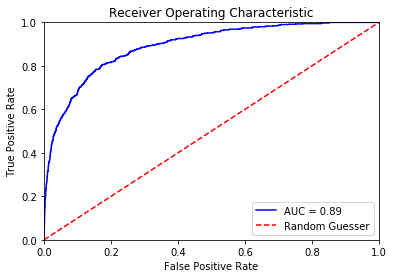

In [68]:
y_pred = model2.predict(dtest)
data.evaluate(y_pred,plot_roc = True)

# NN

## Model

In [134]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def build_model():
    model = Sequential()
    model.add(Dense(256, input_shape = (200,)))
    #model.add(BatchNormalization(momentum = 0.9))
    model.add(Activation("relu"))
    #model.add(Dropout(0.2))
    model.add(Dense(512))
    model.add(BatchNormalization(momentum = 0.9))
    model.add(Activation("relu"))
    #model.add(Dropout(0.2))
    model.add(Dense(1024))
    model.add(BatchNormalization(momentum = 0.9))
    model.add(Activation("relu"))
    #model.add(Dropout(0.2))
    model.add(Dense(2048))
    model.add(BatchNormalization(momentum = 0.9))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1024))
    model.add(BatchNormalization(momentum = 0.9))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(Dense(512))
    model.add(BatchNormalization(momentum = 0.9))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(Dense(256))
    model.add(BatchNormalization(momentum = 0.9))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation = "relu"))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC()])
    return(model)

In [135]:
tf.keras.backend.clear_session()
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               51456     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4

## Data prepo

In [93]:
from datasets import get_datasets
datasets = get_datasets()

In [109]:
data = datasets.small.resplit(0.7,0.15,0.15)

In [110]:
x_train = data.train_split.X.to_numpy()
y_train = data.train_split.y.to_numpy()
x_valid = data.val_split.X.to_numpy()
y_valid = data.val_split.y.to_numpy()
x_test = data.test_split.X.to_numpy()
y_test = data.test_split.y.to_numpy()

In [111]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [112]:
x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_valid)
x_test = scaler.transform(x_test)

In [136]:
callbacks = [
    EarlyStopping(monitor='val_auc', patience=5, mode = 'max'),
    ModelCheckpoint(filepath='../project/models/best_val_weights.h5', save_best_only=True, monitor='val_auc', verbose=1, mode = 'max'),
    ReduceLROnPlateau(monitor='val_auc', factor=0.2, patience=1, min_lr=0.001, mode = 'max',verbose = 1)
]

## Fit

In [137]:
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data = (x_valid, y_valid),
                    callbacks = callbacks
)

Train on 49039 samples, validate on 10509 samples
Epoch 1/50
49024/49039 [============================>.] - ETA: 0s - loss: 0.2703 - auc: 0.7928
Epoch 00001: val_auc improved from -inf to 0.85736, saving model to ../project/models/best_val_weights.h5
49039/49039 [==============================] - 45s 920us/sample - loss: 0.2703 - auc: 0.7928 - val_loss: 0.2352 - val_auc: 0.8574
Epoch 2/50
48992/49039 [============================>.] - ETA: 0s - loss: 0.2412 - auc: 0.8499
Epoch 00002: val_auc improved from 0.85736 to 0.85895, saving model to ../project/models/best_val_weights.h5
49039/49039 [==============================] - 44s 894us/sample - loss: 0.2413 - auc: 0.8500 - val_loss: 0.2335 - val_auc: 0.8590
Epoch 3/50
48960/49039 [============================>.] - ETA: 0s - loss: 0.2290 - auc: 0.8709
Epoch 00003: val_auc did not improve from 0.85895

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.001.
49039/49039 [==============================] - 37s 755us/sample - loss: 0.2

In [138]:
model.load_weights("../project/models/best_val_weights.h5")

In [160]:
y_pred = model.predict(x_test)

In [161]:
y_pred

array([[0.00890079],
       [0.01355121],
       [0.02944377],
       ...,
       [0.18532212],
       [0.04263502],
       [0.01169475]], dtype=float32)

### Evaluation Report

__PRC AUC Score:__ 0.48184

__ROC AUC Score:__ 0.84556



_Following statistics calculated with cut-off = 0.5_

__Accuracy:__ 91.40%

__Balanced Accuracy:__ 62.09%


__Sensitivity:__ 25.48%

__Specificity:__ 98.70%

__Class 1 Precision:__ 68.46%

__Class 1 Recall:__ 25.48%

,Condition Positive,Condition Negative
Positive Prediction,267,123
Negative Prediction,781,9338


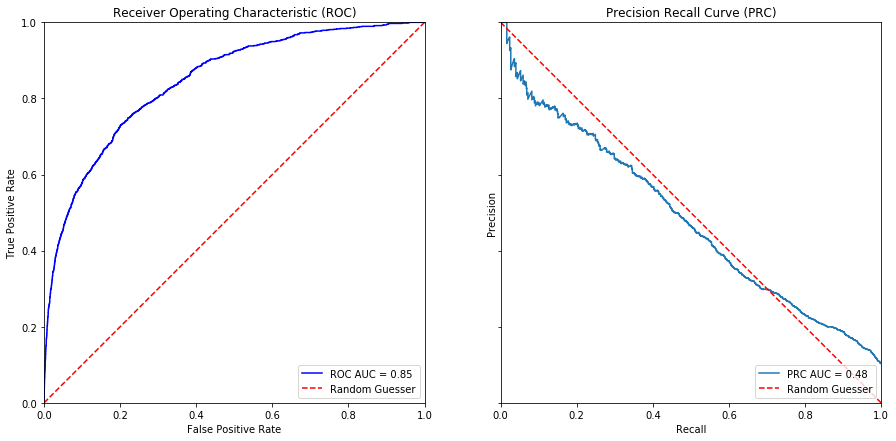

In [162]:
data.evaluate(y_pred[:,0],plot_roc = True)